In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# jupyter nbconvert yourNotebook.ipynb --no-input --to html

import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import json

root_path = "../datasets/"

paths = {
    "WN18RR": {
        "test": os.path.join(root_path, "WN18RR/processed/test.csv"),
        "train": os.path.join(root_path, "WN18RR/processed/train.csv"),
        "valid": os.path.join(root_path, "WN18RR/processed/valid.csv"),
        "defs":"../assets/WordNetDefinitions/wordnet-definitions.txt",
        "etest": os.path.join(root_path, "WN18RR/processed/entity_test.csv"),
        "etrain": os.path.join(root_path, "WN18RR/processed/entity_train.csv"),
        "evalid": os.path.join(root_path, "WN18RR/processed/entity_valid.csv"),
    },
    "FB15K-237":{
        "test": os.path.join(root_path, "FB15K-237/processed/test.csv"),
        "train": os.path.join(root_path, "FB15K-237/processed/train.csv"),
        "valid": os.path.join(root_path, "FB15K-237/processed/valid.csv"),
        "mid2wordnet":os.path.join(root_path, "FB15K-237/processed/processed_wordnet_taxonomy.csv"),
    },
    "Geonames":{
        "all-countries": os.path.join(root_path, "Geonames/processed/allCountries.csv"),
        "feature-codes": os.path.join(root_path, "Geonames/processed/featureCodes_en.csv")
    },
    "UMLS":{
        "rels": os.path.join(root_path, "UMLS/processed/UMLS_skiped_bad_lines.tsv"),
        "entities": os.path.join(root_path, "UMLS/processed/UMLS_entity_types_with_levels.tsv"),
        "tui-2-str": os.path.join(root_path, "UMLS/processed/TUI2STR.json"),
        "tui-2-stn": os.path.join(root_path, "UMLS/processed/TUI2STN.json")
    }
}

# 1. WNN18RR

Tasks that we are interested:
* Entity Type Detection (POS:‌ `Nouns`, `Verbs`, `Adjectives`, and `Adverbs`)
* Relationship Extraction (Ignoring:‌ `_also_see` relationships)



**Original samples from test set:**

|head|relation|tail|
|:---:|:---:|:---:|
|06845599|_member_of_domain_usage|03754979
|00789448|_verb_group |01062739


**Etities Definitions**:

|entity id | entity | definition |
|:---:|:---:|:---:|
|06845599| \__trade_name_NN_1 | a name given to a product or service  |
|03754979 | \__metharbital_NN_1 |‌anticonvulsant drug (trade name Gemonil) used in the treatment of epilepsy  |
|00789448 | \__telephone_VB_1 | get or try to get into communication (with someone) by telephone; "I tried to call you all night"; "Take two aspirin and call me in the morning"|
|01062739 |‌ \__call_VB_9‌| send a message or attempt to reach someone by radio, phone, etc.; make a signal to in order to transmit a message; "Hawaii is calling!"; "A transmitter in Samoa was heard calling"  |


**Samples with etitiy names:**

|head|relation|tail|
|:---:|:---:|:---:|
|\__trade_name_NN_1    |     _member_of_domain_usage  |    \__metharbital_NN_1|
|\__telephone_VB_1     |     _verb_group              |    \__call_VB_9|


**Entity Detection Dataset:**

|entity|type|
|:---:|:---:|
|\__land_reform_NN_1|NN|
|\__cover_VB_1|VB|
|\__phytology_NN_1|NN|
|\__kamet_NN_1|NN|

**Statistics about entities and their duplications**: 
* note 1: these results can be obtained by running `preprare_dataset.py` script with ignoring of `_also_see` relation, **so for final result we should run this script one more time with all the relations that we want**
* **note 2: according to the table there might be overlap between train, test, and valid entities**
| |Train|Test|Valid|Overall| info |
|:---:|:---:|:---:|:---:|:---:|:---|
|Original Size|171,072|6,156|5,986| 183,214 | removing ignored relations also considered!|
|Unique Entities Size|40,476|5,232|5,110|50,818 |removing ignored relations also considered! overall doesnt consider uniques (this number => 50818)|

**Definitions of relationship types:**
* note 1: refrence to this information is [3]
|relationshp| definition|
|:---:|:---|
|[_hypernym](https://globalwordnet.github.io/gwadoc/#hyponym)| IS-A (kind/type of), hyponymy/hyperonymy, A relation between two concepts where concept B is a type of concept A. e.g. poodle-dog-animal |
|[_derivationally_related_form](https://globalwordnet.github.io/gwadoc/#derivation)| Derivation is a relation between two concept where Concept A is the derivationally related form of Concept B., e.g: "yearly is the derivation of year"|
|[_member_meronym](https://globalwordnet.github.io/gwadoc/#mero_member)|  HAS-A (part-of), meronymy-holonymy, A relation between two concepts where concept A is a member/ element of concept B. Meronym and Holonym Membership is a paired relation that denotes group formation and membership. Is different from hyponym as it does not relates a sub-kind of a concept. It links groups to members — Many instances of Concept-A form Concept-B; and Concept-B is composed of many members of Concept-A. e.g. dog-tail, A finger is part of a hand, fleet has member-meronym ship|
|_has_part| A relation between two concepts where concept A makes up a part of concept B., "Y makes up a part of X", e.g hat has part-meronym crown, finger has part-holonym hand| 
|[_synset_domain_topic_of](https://globalwordnet.github.io/gwadoc/#domain_topic)|   Domain Topic is a relation between two concepts where Concept B is a scientific category (e.g. computing, sport, biology, etc.) of concept A., e.g.: football is a domain topic of place-kick|
|[_instance_hypernym](https://globalwordnet.github.io/gwadoc/#instance_hypernym)| the type of an instance, A relation between two concepts where concept A (instance_hyponym) is a type of concept B (instance_hypernym), and where A is an individual entity. A will be a terminal node in the hierarchy. Instances are expressed by proper nouns. An instance hypernym can also be referred to as a type, e.g. manchester has instance_hypernym city|
|[_also_see](https://globalwordnet.github.io/gwadoc/#also)| a word having a loose semantic relation to another word, ‘See Also’ is a self-reciprocal link (the two directions of this relation share the same meaning) — Concept-X relates to Concept-Y, and Concept-Y relates to Concept-X. e.g. farmer see also farmland|
|[_verb_group](https://globalwordnet.github.io/gwadoc/#similar)| "(of words) expressing closely related meanings", group of verbs, This relation coerces PWN Similar to relation for adjectives, Verb Group relation for verb |
|[_member_of_domain_region](https://globalwordnet.github.io/gwadoc/#domain_region)|"A concept which is a geographical / cultural domain pointer of a given concept.", Domain Region is a relation between two concepts where Concept B is a geographical / cultural domain of concept A. e.g. Japan is a domain region of sushi|
|[_member_of_domain_usage](https://globalwordnet.github.io/gwadoc/#has_domain)|A concept which is the scientific category pointer of a given concept. 
|[_similar_to](https://globalwordnet.github.io/gwadoc/#similar)| "(of words) expressing closely related meanings", A relation between two concepts where concept A and concept B are closely related in meaning but are not in the same synset. Similarity is a self-reciprocal link (the two directions of this relation share the same meaning) — Concept-A is similar to Concept-B, and Concept-B is similar to Concept-A., e.g. instrument has near_synonym tools|




**refrences:**

- [1] https://devopedia.org/wordnet#:~:text=WordNet%20is%20a%20network%20of,conceptual%2Dsemantic%20and%20lexical%20relations
- [2] https://iaoa.org/isc2012/docs/fellbaum-trento-due.pdf
- [3] https://globalwordnet.github.io/gwadoc/#domain_topic
- [4] https://wn.readthedocs.io/en/latest/guides/wordnet.html
- [5] https://wordnet.princeton.edu/documentation/wninput5wn
- [6] [Alphabetical list of part-of-speech tags used in the Penn Treebank Project](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html)

,head,relation,tail,head-def,tail-def,head-entity-type,tail-entity-type
0,__land_reform_NN_1,_hypernym,__reform_NN_1,a redistribution of agricultural land (especia...,a change for the better as a result of correct...,NN,NN
1,__cover_VB_1,_derivationally_related_form,__covering_NN_2,provide with a covering or cause to be covered...,an artifact that covers something else (usuall...,VB,NN


The size of train set is:85536
The size of test set is:3078
The size of valid set is:2993
The size of overall dataseet is:91607
The size of the definitions are:40943
The size of relations is: 10
--------------------------------------------------
The size of entity type detection train set is:40476
The size of entity type detection test set is:5232
The size of entity type detection valid set is:5110
The size of overall entity type detection dataseet is:50818
The size of entity type classes is: 4


Text(0.5, 1.0, 'Overall dataset entity types frequencies')

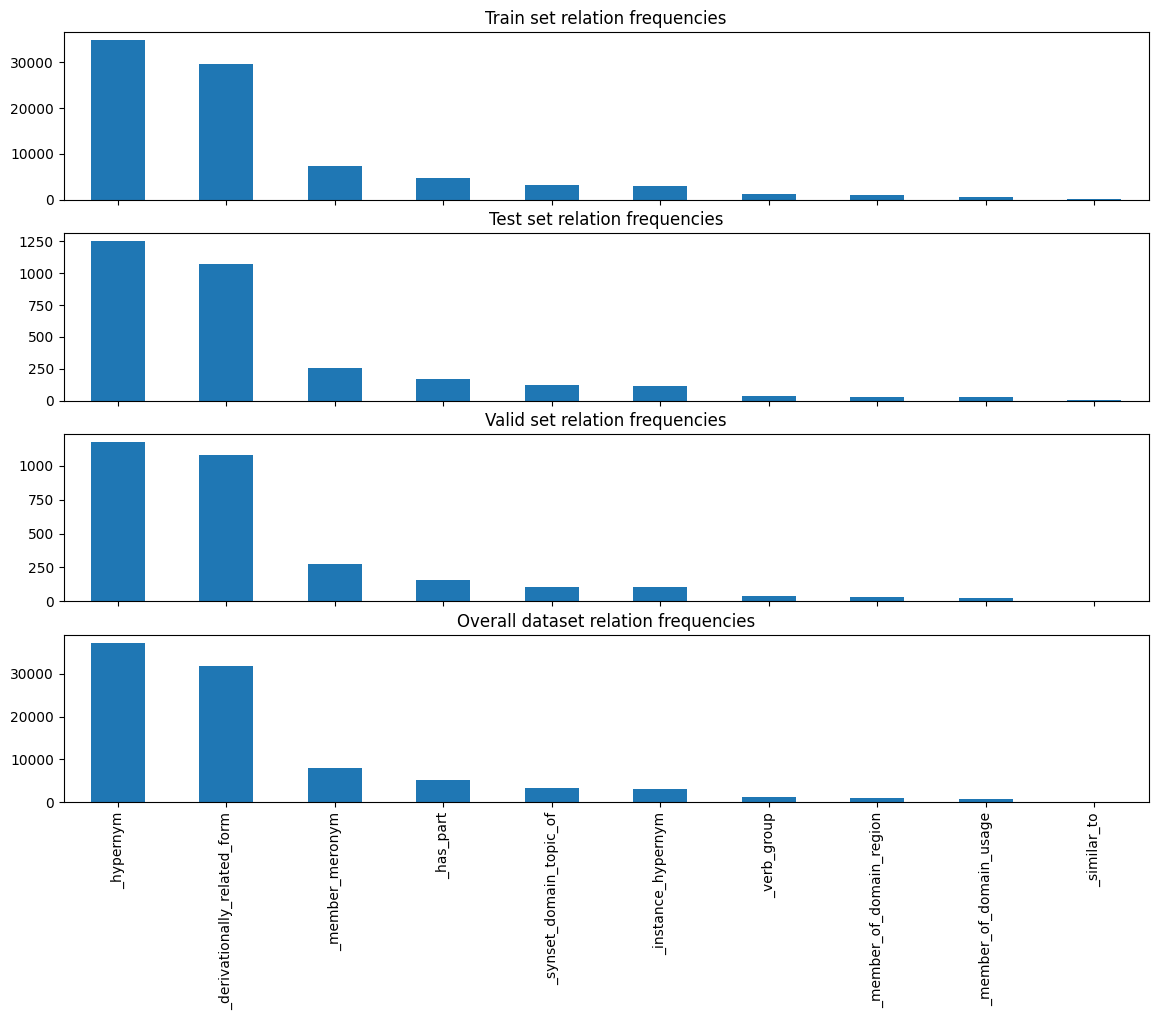

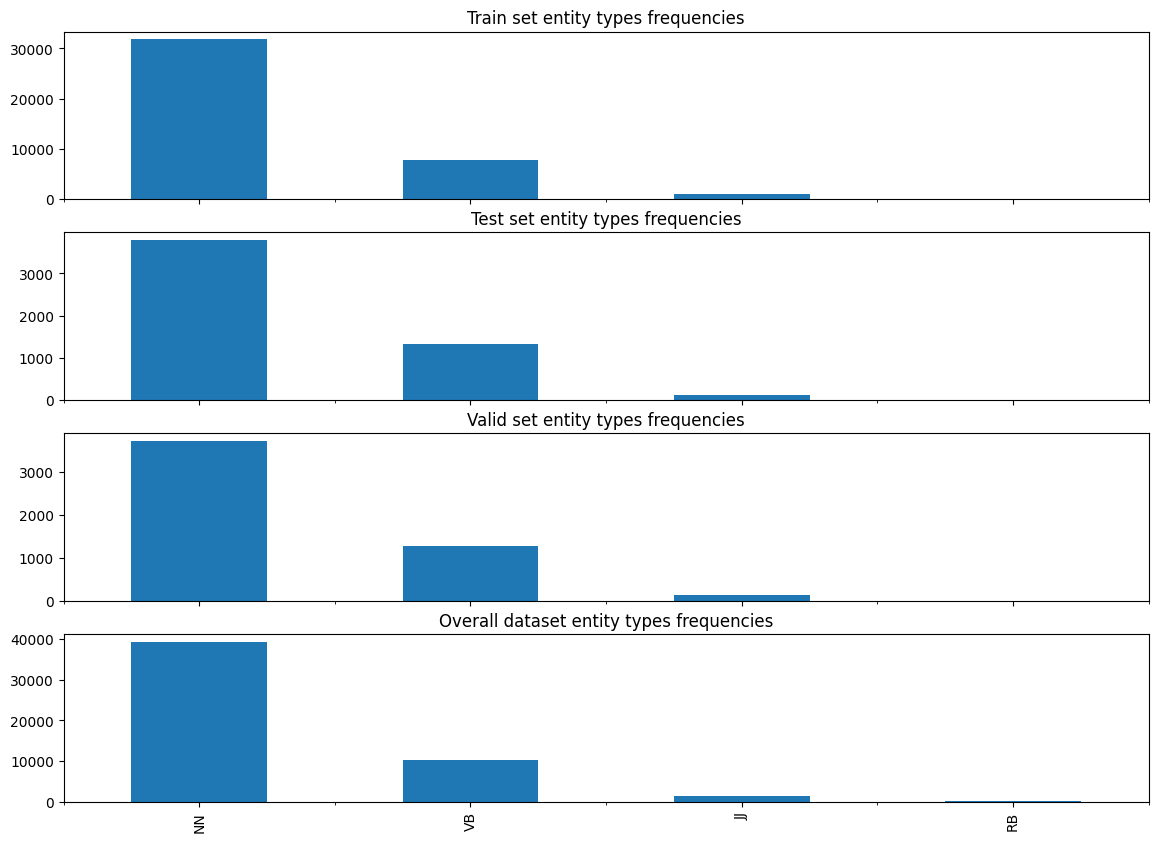

In [9]:

dataset = "WN18RR"

train = pd.read_csv(paths[dataset]['train'])
test  = pd.read_csv(paths[dataset]['test'])
valid = pd.read_csv(paths[dataset]['valid'])
wn18rr= pd.concat([train, test, valid], axis=0)

etrain = pd.read_csv(paths[dataset]['etrain'])
etest  = pd.read_csv(paths[dataset]['etest'])
evalid = pd.read_csv(paths[dataset]['evalid'])
ewn18rr= pd.concat([etrain, etest, evalid], axis=0)

display(wn18rr.head(2))

definitions_df = pd.read_csv(paths[dataset]['defs'], sep='\t', header=None, names=['entity_id', 'entity', 'definitions'])

print(f"The size of train set is:{train.shape[0]}")
print(f"The size of test set is:{test.shape[0]}")
print(f"The size of valid set is:{valid.shape[0]}")
print(f"The size of overall dataseet is:{wn18rr.shape[0]}")
print(f"The size of the definitions are:{definitions_df.shape[0]}")
print(f"The size of relations is: {len(wn18rr['relation'].value_counts())}")
print("-"*50)
print(f"The size of entity type detection train set is:{etrain.shape[0]}")
print(f"The size of entity type detection test set is:{etest.shape[0]}")
print(f"The size of entity type detection valid set is:{evalid.shape[0]}")
print(f"The size of overall entity type detection dataseet is:{ewn18rr.shape[0]}")
print(f"The size of entity type classes is: {len(ewn18rr['type'].value_counts())}")

fig, axs = plt.subplots(4, 1, figsize=(14,10), sharex=True)
train['relation'].value_counts().plot(ax=axs[0], kind='bar')
axs[0].set_title('Train set relation frequencies')

test['relation'].value_counts().plot(ax=axs[1], kind='bar')
axs[1].set_title('Test set relation frequencies')

valid['relation'].value_counts().plot(ax=axs[2], kind='bar')
axs[2].set_title('Valid set relation frequencies')

wn18rr['relation'].value_counts().plot(ax=axs[3], kind='bar')
axs[3].set_title('Overall dataset relation frequencies')

############################################################################################

fig, axs = plt.subplots(4, 1, figsize=(14,10), sharex=True)
etrain['type'].value_counts().plot(ax=axs[0], kind='bar')
axs[0].set_title('Train set entity types frequencies')

etest['type'].value_counts().plot(ax=axs[1], kind='bar')
axs[1].set_title('Test set entity types frequencies')

evalid['type'].value_counts().plot(ax=axs[2], kind='bar')
axs[2].set_title('Valid set entity types frequencies')

ewn18rr['type'].value_counts().plot(ax=axs[3], kind='bar')
axs[3].set_title('Overall dataset entity types frequencies')

# 2. FB15K-237

```json
{
       'Level-1': ['wordnet_person_100007846', 'wordnet_organization_108008335', 'wordnet_body_of_water_109225146', 
                   'wordnet_product_104007894', 'wordnet_event_100029378'],
       'Level-2-event': ['wordnet_social_event_107288639', 'wordnet_festival_100517728','wordnet_festival_115162388', 
                         'wordnet_conference_108308497', 'wordnet_show_106619065','wordnet_show_100520257'],

       'Level-2-organization': ['wordnet_musical_organization_108246613', 'wordnet_party_108256968', "wordnet_world_organization_108294696",
                                'wordnet_enterprise_108056231', 'wordnet_nongovernmental_organization_108009834', 'wordnet_institution_108053576', 
                                "wordnet_government_108050678"], 
       'Level-3-organization-institution':["wordnet_educational_institution_108276342", "wordnet_university_108286569","wordnet_financial_institution_108054721",
                                           "wordnet_medical_institution_108053905", "wordnet_naval_academy_108279665", "wordnet_public_school_108410282",
                                           "wordnet_academy_108277805","wordnet_nursing_school_108283757", "wordnet_law_school_108283051",
                                           "wordnet_community_college_108282542", "wordnet_university_108286569", "wordnet_normal_school_108412620",
                                          "wordnet_graduate_school_108282696"],

       'Level-3-organization-enterprise': ['wordnet_electronics_company_108003035', 'wordnet_insurance_company_108070465','wordnet_investment_company_108070850',
                                           'wordnet_shipping_company_108003717', "wordnet_industry_108065234","wordnet_corporation_108059412",
                                           'wordnet_company_108058098','wordnet_electronics_company_108003035','wordnet_power_company_108186393',
                                           'wordnet_telephone_company_108186221', 'wordnet_food_company_108003427','wordnet_subsidiary_company_108003935',
                                           'wordnet_film_company_108003173', 'wordnet_holding_company_108185369','wordnet_broadcasting_company_108002015',
                                           'wordnet_drug_company_108002578', "wordnet_commercial_enterprise_108065093", 'wordnet_motion-picture_film_103789400'],

       'Level-2-body_of_water': ['wordnet_stream_109448361', 'wordnet_lake_109328904', 'wordnet_ocean_109376198', 
                                 'wordnet_bay_109215664', 'wordnet_sea_109426788', 'wordnet_waterfall_109475292', 'wordnet_waterway_109476331'],
       'Level-3-body_of_water-sea': ['wordnet_seaport_108639058', 'wordnet_seashore_109428293', 'wordnet_shore_109433442'],


       'Level-2-person': ['wordnet_artist_109812338', 'wordnet_officeholder_110371450', 'wordnet_writer_110794014', 'wordnet_writer_110801291',
                          'wordnet_scientist_110560637', 'wordnet_politician_110450303', 'wordnet_creator_109614315', 'wordnet_people_107942152',
                          'wordnet_female_109619168', 'wordnet_woman_110787470', 'wordnet_good_person_110138767', 'wordnet_director_110014939',
                          'wordnet_director_110015215', 'wordnet_politician_110451263', 'wordnet_lawyer_110249950',

                          'wordnet_doctor_110020890', 'wordnet_player_110439851', 'wordnet_male_109624168', 'wordnet_man_110287213'], 


       'Level-3-person-docktor':['wordnet_ear-nose-and-throat_doctor_110059323', 'wordnet_nurse_110366966', 'wordnet_psychiatrist_110488016',
                                'wordnet_neurologist_110354265'],

       'Level-3-person-writer': ['wordnet_journalist_110224578', 'wordnet_poet_110444194', 'wordnet_novelist_110363573', 'wordnet_composer_109947232',
                                 'wordnet_scriptwriter_110564905', 
                                 'wordnet_dramatist_110030277', 'wordnet_essayist_110064405', 'wordnet_biographer_109855433',
                                 'wordnet_sports_writer_110640084', 'wordnet_screenwriter_110564400', 'wordnet_scriptwriter_110564905',
                                 'wordnet_copywriter_109965021', 'wordnet_songwriter_110624540','wordnet_ghostwriter_110128748',
                                 'wordnet_speechwriter_110631654', 'wordnet_photojournalist_110427223' ], 

    'Level-3-person-scientist':['wordnet_social_scientist_110619642','wordnet_biologist_109855630','wordnet_physicist_110428004','wordnet_publisher_108062623',
                                     'wordnet_mathematician_110301261', 'wordnet_chemist_109913824', 'wordnet_linguist_110264437', 'wordnet_scholar_110557854',
                                     'wordnet_psychologist_110488865', 'wordnet_geologist_110127689', 'wordnet_computer_scientist_109951070', 
                                     'wordnet_research_worker_110523076', 'wordnet_cognitive_scientist_109934647', "wordnet_social_anthropologist_110618465",
                                     'wordnet_paleontologist_110394786', 'wordnet_analyst_109790278', 'wordnet_aerospace_engineer_109776079', 
                               'wordnet_engineer_109615807'], 

    'Level-3-person-player': ['wordnet_football_player_110101634','wordnet_ballplayer_109835506','wordnet_soccer_player_110618342',
                              'wordnet_golfer_110136959', 'wordnet_tennis_player_110701180','wordnet_basketball_player_109842047',
                              'wordnet_card_player_109894654','wordnet_most_valuable_player_110332257','wordnet_lacrosse_player_110242682',
                              'wordnet_bridge_player_109875353','wordnet_hockey_player_110179291','wordnet_chess_player_109915834'],

    'Level-3-person-artist': ['wordnet_painter_110391653', 'wordnet_sculptor_110566072', 'wordnet_photographer_110426749', 
                                  'wordnet_illustrator_109812068', 'wordnet_printmaker_110475687', 'wordnet_recorder_player_110512109',
                                  'wordnet_sitar_player_110603851', 'wordnet_actor_109767197', 'wordnet_tenor_saxophonist_110701962',
                                  'wordnet_lyricist_110277912', 'wordnet_folk_singer_110099093', 'wordnet_cameraman_109889539', 
                                  'wordnet_satirist_110552742', 'wordnet_performer_110415638', 'wordnet_actor_109765278']
       }
```

Original samples from train set:

|head|relation|tail|
|:---:|:---:|:---:|
|/m/015qsq|/film/film/language|/m/02bjrlw|
|/m/05hs4r|/music/genre/artists |/m/01pbxb|


Converting MIDs to names using `type.object.name` values from Freebase dumps. We searched **3 billion** Freebase dumps to extract names that are available in our FB15K-237 dataset. In the end, we obtained 1 name for `14476` entities, 2 names for `41` entities (we select only the first entities and ignored the last one), and for 24 entities we found nothing in Freebase dumps. In the end, we obtained definitions for **14517** entities from Freebase dumps.

The following is a sample of above-mentioned work:

|mid|name|
|:---:|:---:|
|/m/015qsq| Serpico |
|/m/02bjrlw| Italian Language |
|/m/05hs4r| Heartland rock | 
|/m/01pbxb| Bob Seger |


Processed WordNet Taxonomy extarction using `freebaseTypes.tsv` file from [1] paper:

|MID | EntityTypes‌ |
|:---:|:---:|
|/m/015qsq|['wordnet_abstraction_100002137', 'wordnet_psychological_feature_100023100', 'wordnet_physical_entity_100001930', 'wordnet_movie_106613686', 'wordnet_creation_103129123', ... ] |
|/m/02bjrlw|  ['wordnet_communication_100033020', 'wordnet_abstraction_100002137', 'wordnet_language_106282651'] |
|/m/05hs4r| ['wordnet_auditory_communication_107109019', 'wordnet_attribute_100024264', 'wordnet_property_104916342',  ... ] |
|/m/01pbxb| ['wordnet_winner_110782940', 'wordnet_entertainer_109616922', 'wordnet_musician_110340312', 'wordnet_songwriter_110624540', ... ]|

Number of Nan Values in Train, Test, and Valid that we ignored them:

```
The size of nans in train set is: 189692
The size of nans in test set is: 16011
The size of nans in valid set is: 13699
The size of nans in overall dataseet is:219,402
```

- NOTE 1 :‌ Freebase does not provide any class hierarchy with `rdfs:subClassOf` relations and Wikidata does not instantiate classes explicitly as classes, but uses instead only “subclass of” (wdt:P279) relations, the method of calculating the number of classes depends on the considered KG.
- NOTE 2: Classes: Freebase lacks a class hierarchy and subclasses of classes are often in different domains (for instance, the classes freebase:music.artist and sportsmen freebase:sports.pro_athlete are logically a subclass of the class people freebase: person.people but not explicitly stated as such), which makes it difficult to find suitable sub- and superclasses/

https://www.uni-trier.de/fileadmin/fb2/LDV/Rettinger/publications/KG-Comparison-SWJ-Article.pdf




[1] [Do Embeddings Actually Capture Knowledge Graph Semantics?](/documents/do_embeddings_actually_capture_knowledge_graph_semantics_.pdf)
[2] http://www.akbc.ws/2017/papers/22_paper.pdf 


,head-mid,relation,tail-mid,head-mid2name,tail-mid2name,head-mid2taxonomy,tail-mid2taxonomy,head-levels,tail-levels
0,/m/017dcd,/tv/tv_program/regular_cast./tv/regular_tv_app...,/m/06v8s0,Mighty Morphin Power Rangers,Wendee Lee,"['wordnet_event_100029378', 'wordnet_show_1066...","['wordnet_writer_110794014', 'wordnet_director...","['Level-1', 'Level-2-event']","['Level-1', 'Level-3-person-writer', 'Level-2-..."
1,/m/01sl1q,/award/award_winner/awards_won./award/award_ho...,/m/044mz_,Michelle Rodriguez,Naveen Andrews,"['wordnet_writer_110794014', 'wordnet_female_1...","['wordnet_man_110287213', 'wordnet_person_1000...","['Level-1', 'Level-3-person-writer', 'Level-2-...","['Level-1', 'Level-3-person-scientist', 'Level..."


The size of train set is:82423
The size of test set is:4455
The size of valid set is:3836
The size of overall dataseet is:90714
The size of the mid2wordnet_df are:8711
The size of relations is: 142
The size of relation-domains is: 25


Text(0.5, 1.0, 'Overall dataset relation domain frequencies')

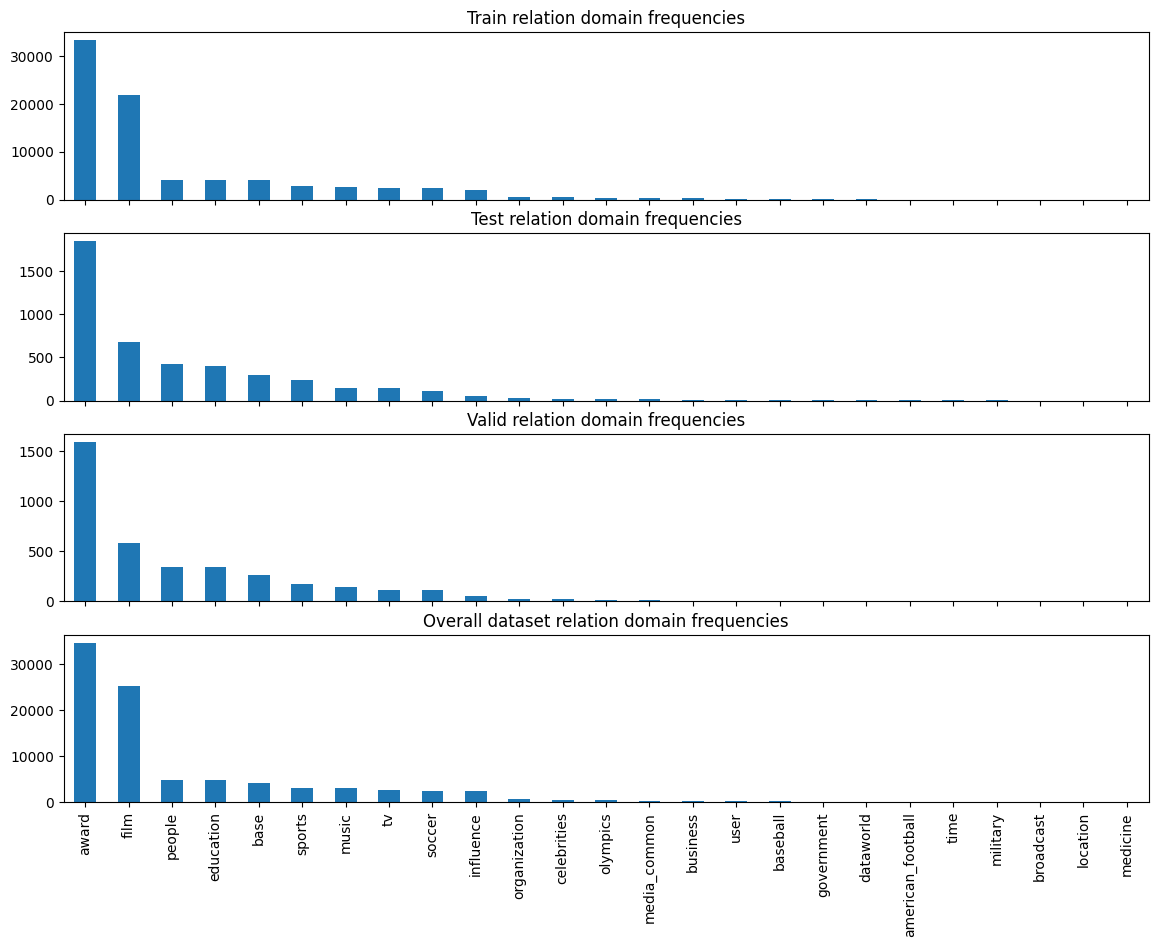

In [24]:
dataset = "FB15K-237"

train = pd.read_csv(paths[dataset]['train'])
test  = pd.read_csv(paths[dataset]['test'])
valid = pd.read_csv(paths[dataset]['valid'])
fb15k= pd.concat([train, test, valid], axis=0)

display(fb15k.head(2))

mid2wordnet_df = pd.read_csv(paths[dataset]['mid2wordnet'])


train['relation-domain'] = train['relation'].apply(lambda x: x.split("/")[1])
test['relation-domain'] = test['relation'].apply(lambda x: x.split("/")[1])
valid['relation-domain'] = valid['relation'].apply(lambda x: x.split("/")[1])
fb15k['relation-domain'] = fb15k['relation'].apply(lambda x: x.split("/")[1])

print(f"The size of train set is:{train.shape[0]}")
print(f"The size of test set is:{test.shape[0]}")
print(f"The size of valid set is:{valid.shape[0]}")
print(f"The size of overall dataseet is:{fb15k.shape[0]}")
print(f"The size of the mid2wordnet_df are:{mid2wordnet_df.shape[0]}")
print(f"The size of relations is: {len(fb15k['relation'].value_counts())}")
print(f"The size of relation-domains is: {len(fb15k['relation-domain'].value_counts())}")


fig, axs = plt.subplots(4, 1, figsize=(14,10), sharex=True)
train['relation-domain'] .value_counts().plot(ax=axs[0], kind='bar')
axs[0].set_title('Train relation domain frequencies')

test['relation-domain'].value_counts().plot(ax=axs[1], kind='bar')
axs[1].set_title('Test relation domain frequencies')

valid['relation-domain'].value_counts().plot(ax=axs[2], kind='bar')
axs[2].set_title('Valid relation domain frequencies')

fb15k['relation-domain'].value_counts().plot(ax=axs[3], kind='bar')
axs[3].set_title('Overall dataset relation domain frequencies')

number of unique WordNet Types are: 140


Text(0.5, 1.0, 'WordNet Type Frequencies > 50 , Count = 56')

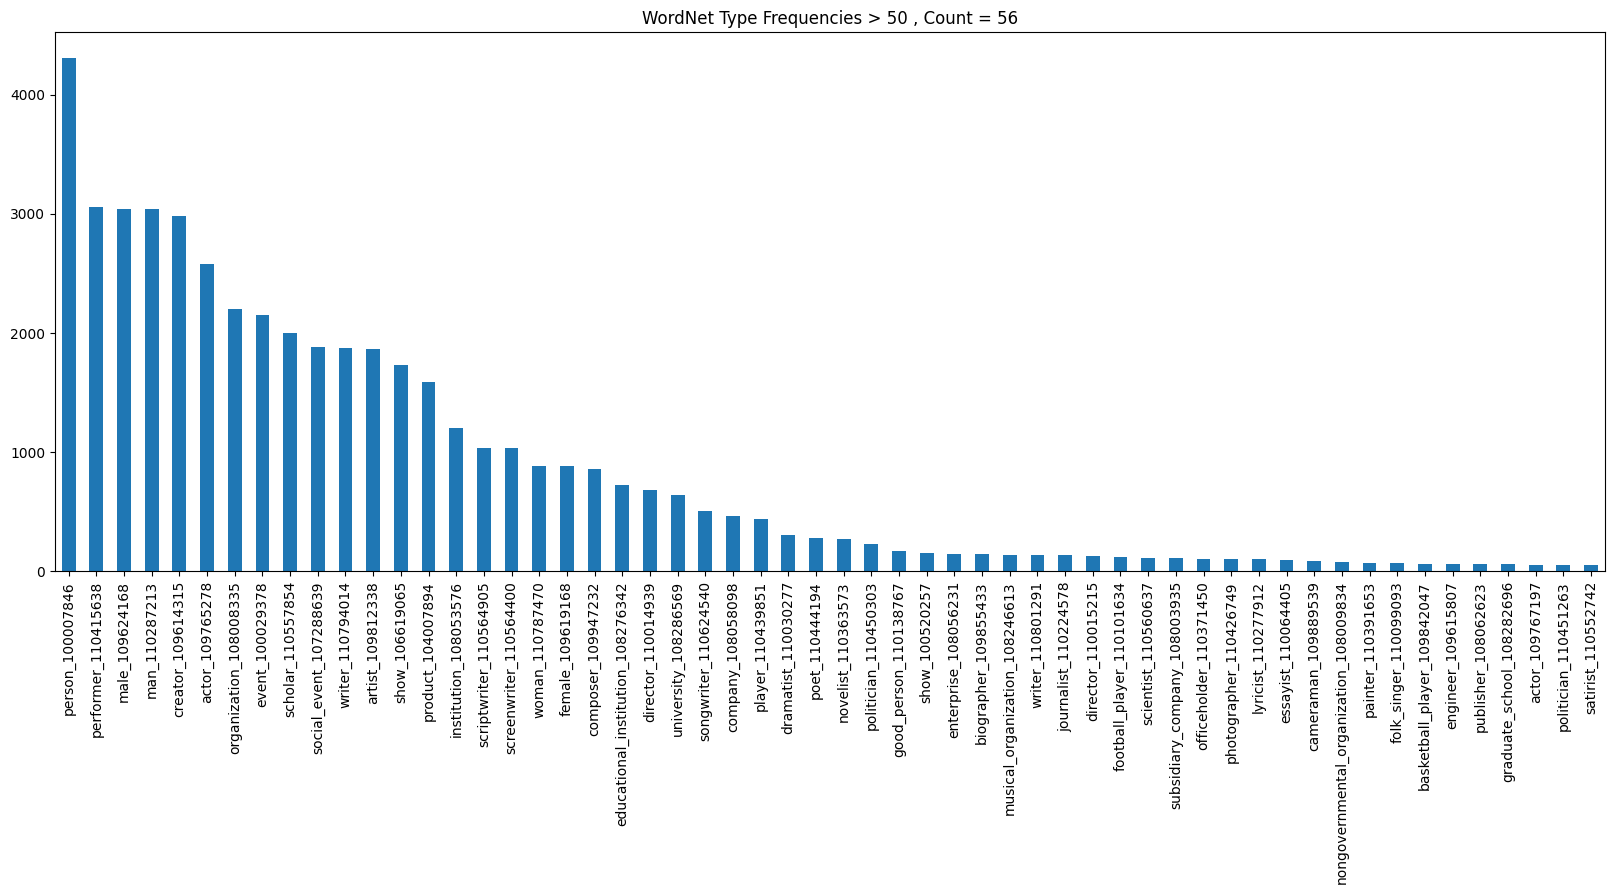

In [26]:
# wordnet_types =[' '.join(type_.split("_")[1:-1]) for types in mid2wordnet_df["wordnetid"].tolist() for type_ in eval(types)]
wordnet_types =['_'.join(type_.split("_")[1:]) for types in mid2wordnet_df["wordnetid"].tolist() for type_ in eval(types)]
print(f"number of unique WordNet Types are: {len(set(wordnet_types))}")

df = pd.DataFrame(data={"wordnet": wordnet_types})

fig, axs = plt.subplots(1, 1, figsize=(20,7))
df['wordnet'].value_counts().loc[lambda x: x > 50].plot(ax=axs, kind='bar')

axs.set_title(f"WordNet Type Frequencies > 50 , Count = {len(df['wordnet'].value_counts().loc[lambda x: x > 50])}")

In [30]:
# levels =[level  for levels in fb15k["tail-levels"].tolist() for level in eval(levels)] + [level  for levels in fb15k["head-levels"].tolist() for level in eval(levels)]


# df = pd.DataFrame(data={"levels": levels})

# fig, axs = plt.subplots(1, 1, figsize=(20,7))

# df['levels'].value_counts().plot(ax=axs, kind='bar')

# axs.set_title(f"Levels Frequencies, Count = {len(df['levels'].value_counts())}")

In [29]:
df['levels'].value_counts()

Level-1                             180330
Level-2-person                       99629
Level-3-person-artist                78295
Level-3-person-scientist             51117
Level-3-person-writer                47849
Level-2-event                        44504
Level-2-organization                 18213
Level-3-organization-enterprise       9085
Level-3-organization-institution      8267
Level-3-person-player                 6132
Level-3-person-docktor                 213
Level-2-body_of_water                   43
Level-3-body_of_water-sea                2
Name: levels, dtype: int64

# 3.GeoNames

Feature codes in level 1 described as follows (9 in total):
- A: country, state, region
- H:‌ stream, lake 
- L : parks,area
- P : city, village
- R : road, railroad
- S : spot, building, farm 
- T : mountain,hill,rock 
- U : undersea 
- V : forest,heath

Also feature codes for level2 and level3 are:
- Number of feature codes in Level 2: **404**
- Number of feature codes in Level 3: **675**

To obtain levels we followed the recursive functions intuitions with devide and conqure approach.

* List of countries: https://www.geonames.org/countries/
* The full GeoNames described here: http://www.geonames.org/export/codes.html

#### Obtaining hierarchy

To obtain levels we followed the recursive functions algorithm with divide and conquer approach. The feature code consist of level 1 (for example in A.ADM1  feature code A is identifier of level 1 class). First, we split feature codes into level 1 and the rest feed into our algorithm to identity hierarchies using feature codes.  The recursive methods consist of a single main function and another function that calls the main function until reaches a condition‌ (or stop point) that we have answer. The stop point for our algorithm is start level which is 1. 

The main function gets feature codes and depth identifier as input and walks through feature codes one step and categories feature codes based on length (the `depths identifier + n`), for our case we select n=2 as a starting point since we obtained level 1 before. For example for the following samples:

```
['ADM1', 'ADM1H', 'ADM2', 'ADM2H', 'ADM3', 'ADM3H', 'ADM4', 'ADM4H', 'ADM5', 'ADM5H', 'ADMD', 'ADMDH', 'LTER', 'PCL', 'PCLD', 'PCLF', 'PCLH', 'PCLI', 'PCLIX', 'PCLS', 'PRSH', 'TERR', 'ZN', 'ZNB']
```

And for depth 1 at time we have the following‌: 

```json
{'ADM': ['ADM1',
  'ADM1H',
  'ADM2',
  'ADM2H',
  'ADM3',
  'ADM3H',
  'ADM4',
  'ADM4H',
  'ADM5',
  'ADM5H',
  'ADMD',
  'ADMDH'],
 'LTE': ['LTER'],
 'PCL': ['PCL', 'PCLD', 'PCLF', 'PCLH', 'PCLI', 'PCLIX', 'PCLS'],
 'PRS': ['PRSH'],
 'TER': ['TERR'],
 'ZN': ['ZN'],
 'ZNB': ['ZNB']
 }
```
In this example, the depth identifier is set to 1 (1 depth move at this time), so max lenght for categorization is depth+n = 3, then we may find strings that matches in a categories with max lenght of 3. For example AMD1, AMD1H, ... are in AMD category.

Considering this main function, we are able to solve small lists again and attach to the depths in order to form a depths. We put only one condition 

```c
Dict HIERARCHY [FCodes:‌ List, Depth: Int, StartingDepth: Int=0]
     if StartingDepth < Depth - 1:
         FCodes =  MAIN(FCodes, StartingDepth), Depth, StartingDepth + 1)
         For FCode in FCodes:
             FCodes = HIERARCHY(FCode, Depth, StartingDepth + 1)
     return FCode
```

as a resut for depth=3 we obtained the following heirarchy:
```json
{'AD': {'ADM': ['ADM1',
   'ADM1H',
   'ADM2',
   'ADM2H',
   'ADM3',
   'ADM3H',
   'ADM4',
   'ADM4H',
   'ADM5',
   'ADM5H',
   'ADMD',
   'ADMDH']},
 'LT': {'LTE': ['LTER']},
 'PC': {'PCL': ['PCL', 'PCLD', 'PCLF', 'PCLH', 'PCLI', 'PCLIX', 'PCLS']},
 'PR': {'PRS': ['PRSH']},
 'TE': {'TER': ['TERR']},
 'ZN': {'ZN': ['ZN'], 'ZNB': ['ZNB']}}
```

Which represents level 2 (first keys) and level 3 (second inner keys) for feature codes.

#### Plots

In [2]:
dataset = "Geonames"

all_countries_df = pd.read_csv(paths[dataset]['all-countries'])
feature_codes    = pd.read_csv(paths[dataset]['feature-codes'])

display(all_countries_df.head(5))

display(feature_codes.head(5))

print(f"The size of dataset set is:{all_countries_df.shape[0]}")
print(f"The size of feature codes set is:{feature_codes.shape[0]}")
print(f"Number of countries are: {len(all_countries_df['country-code'].value_counts())}")
print("-"*50)
print(f"Number of feature codes in Level 1: {len(all_countries_df['level-1'].value_counts())}")
print(f"Number of feature codes in Level 2: {len(all_countries_df['level-2'].value_counts())}")
print(f"Number of feature codes in Level 3: {len(all_countries_df['level-3'].value_counts())}")
print("-"*50)

,name,asciiname,country-code,level-1,level-2,level-3
0,Pic de Font Blanca,Pic de Font Blanca,AD,T,PK,PK
1,Roc Mélé,Roc Mele,AD,T,MT,MT
2,Pic des Langounelles,Pic des Langounelles,AD,T,PK,PK
3,Pic de les Abelletes,Pic de les Abelletes,AD,T,PK,PK
4,Estany de les Abelletes,Estany de les Abelletes,AD,H,LK,LK


,feature-code,name,description,level-1,level-2,level-3
0,A.ADM1,first-order administrative division,a primary administrative division of a country...,A,ADM,ADM1
1,A.ADM1H,historical first-order administrative division,a former first-order administrative division,A,ADM,ADM1H
2,A.ADM2,second-order administrative division,a subdivision of a first-order administrative ...,A,ADM,ADM2
3,A.ADM2H,historical second-order administrative division,a former second-order administrative division,A,ADM,ADM2H
4,A.ADM3,third-order administrative division,a subdivision of a second-order administrative...,A,ADM,ADM3


The size of dataset set is:12350450
The size of feature codes set is:680
Number of countries are: 252
--------------------------------------------------
Number of feature codes in Level 1: 9
Number of feature codes in Level 2: 404
Number of feature codes in Level 3: 675
--------------------------------------------------


Text(0.5, 1.0, 'Level-3 Frequencies > 5000')

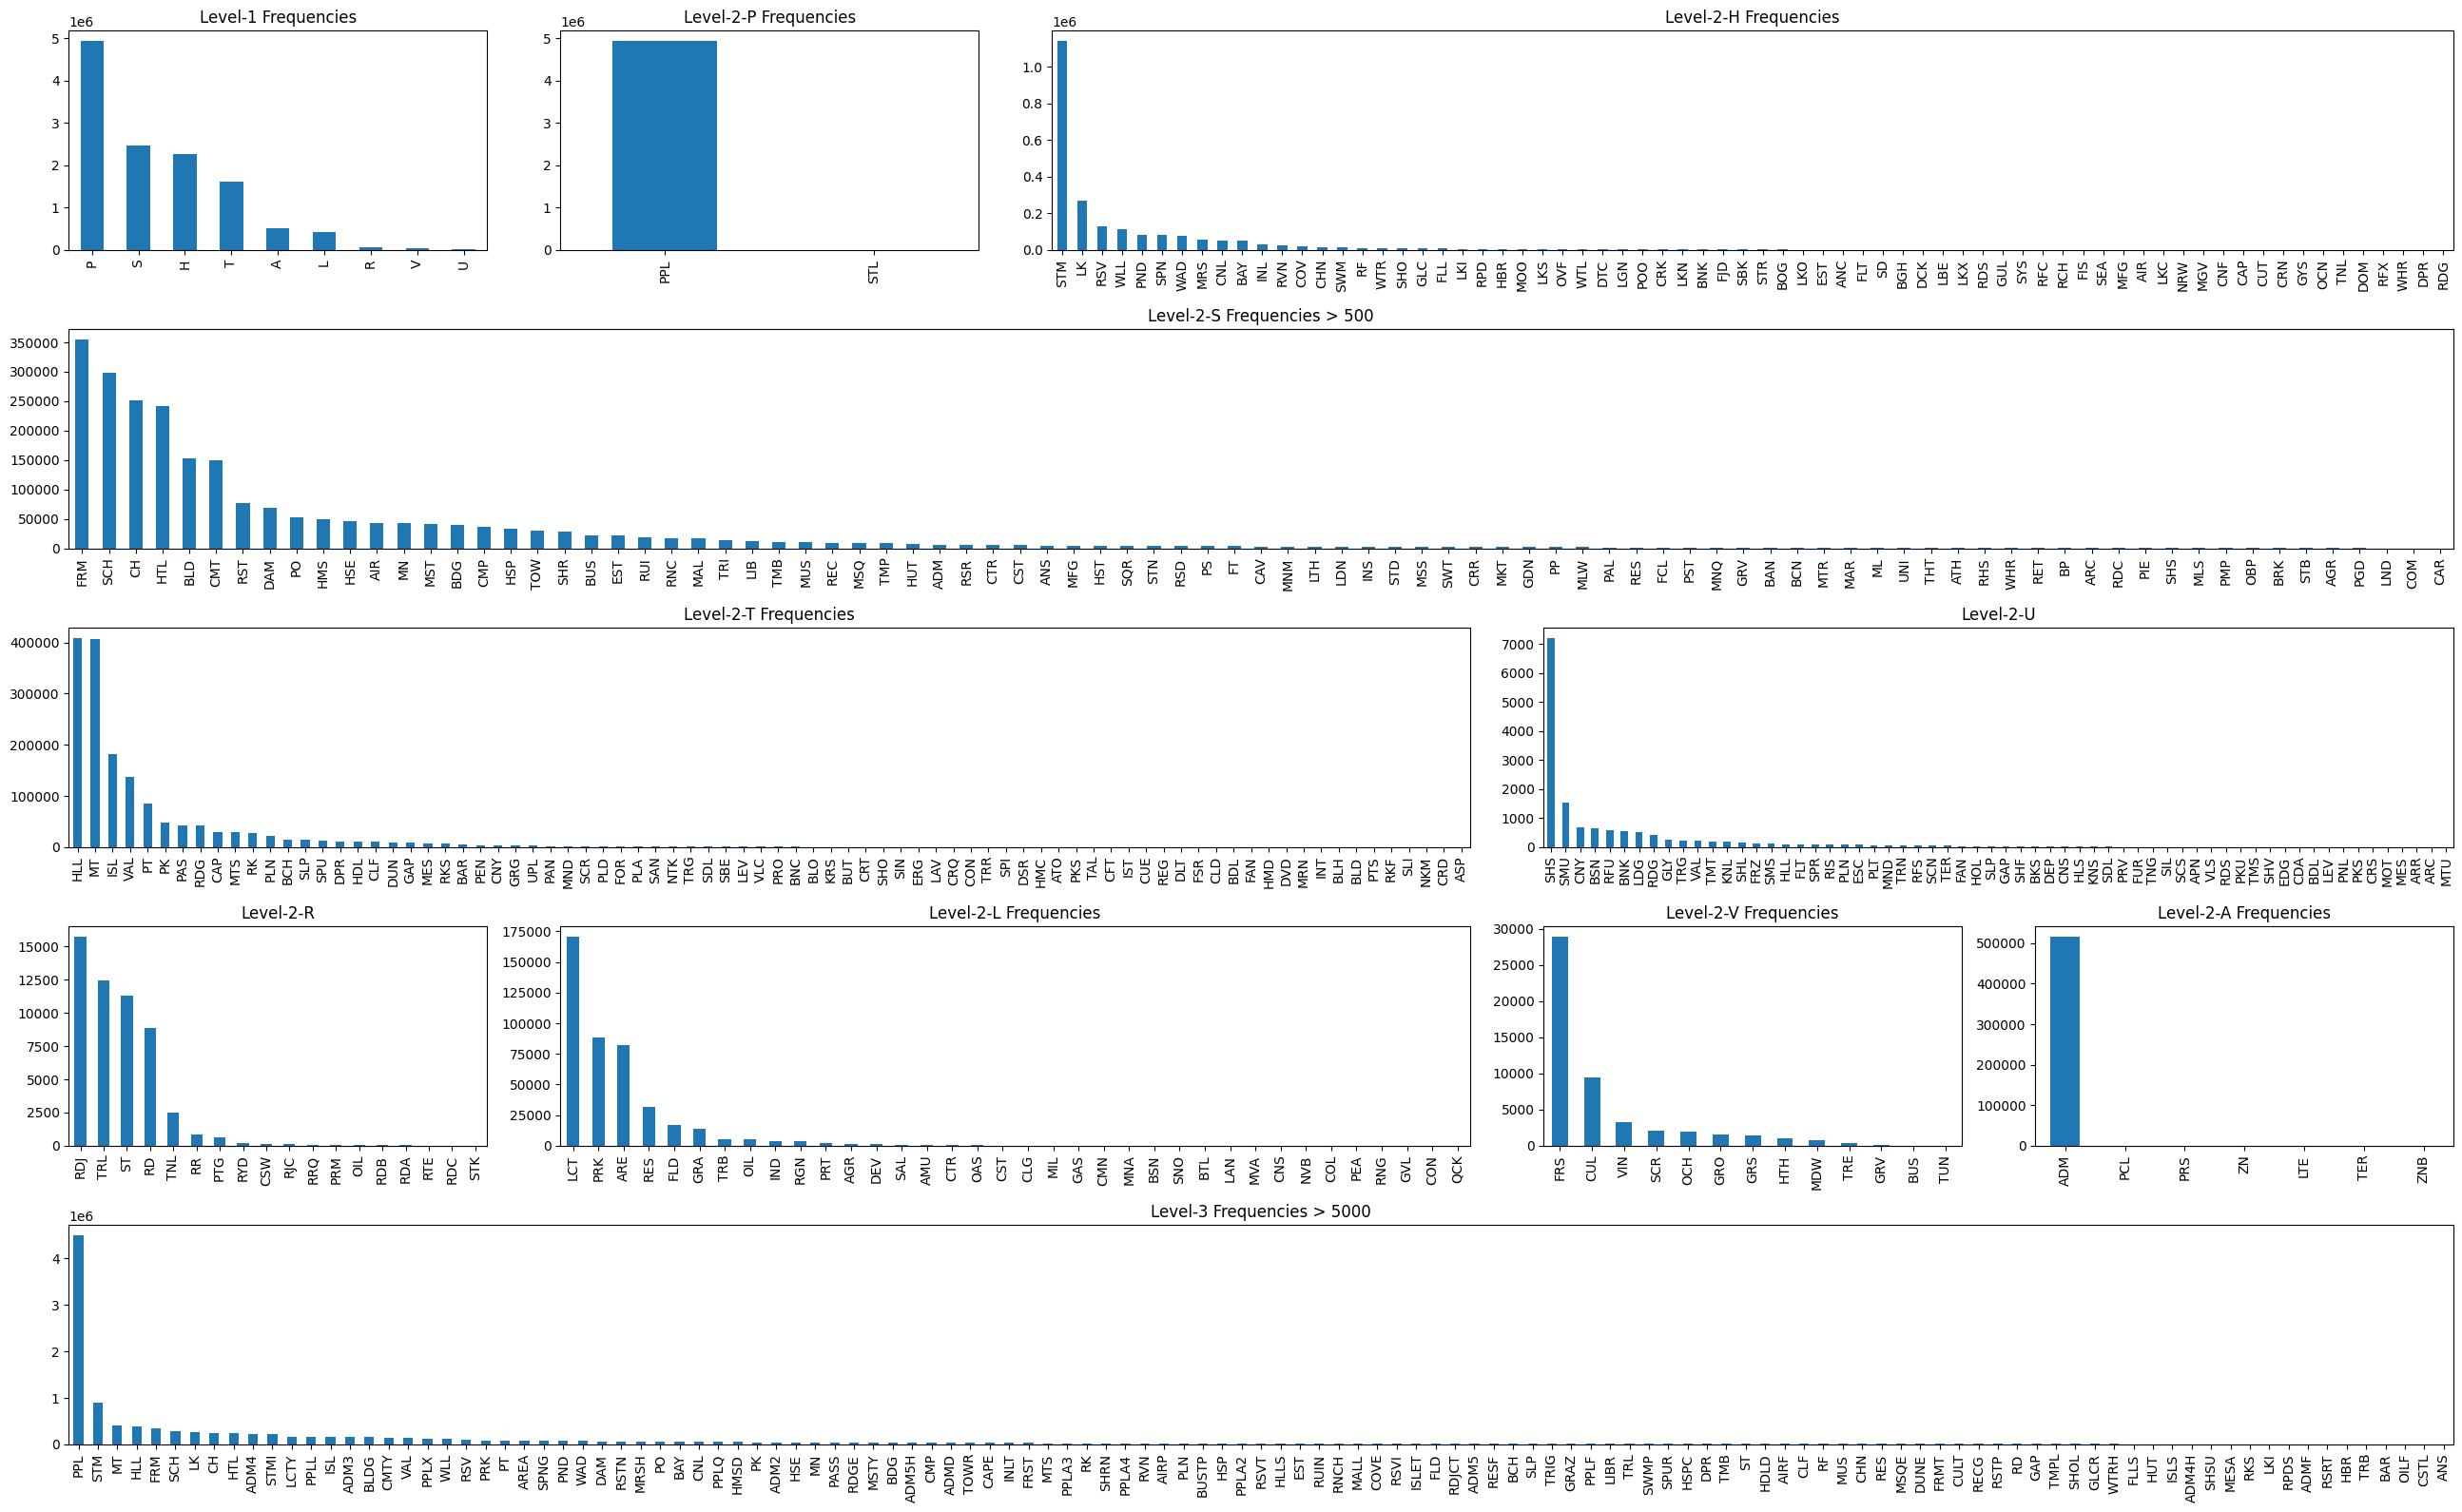

In [4]:
fig = plt.figure(figsize=(26,16))
# plt.rcParams["figure.autolayout"] = True

ax1 = fig.add_subplot(5, 5, 1)
all_countries_df['level-1'].value_counts().plot(ax=ax1, kind='bar')
ax1.set_title('Level-1 Frequencies')

ax2 = fig.add_subplot(5, 5, 2)
all_countries_df.groupby('level-1').get_group("P")['level-2'].value_counts().plot(ax=ax2, kind='bar')
ax2.set_title('Level-2-P Frequencies')

ax4 = fig.add_subplot(5, 5, (3, 5))
all_countries_df.groupby('level-1').get_group("H")['level-2'].value_counts().plot(ax=ax4, kind='bar', legend=False)
ax4.set_title('Level-2-H Frequencies')

ax3 = fig.add_subplot(5, 5, (6, 10))
all_countries_df.groupby('level-1').get_group("S")['level-2'].value_counts().loc[lambda X: X>500].plot(ax=ax3, kind='bar', legend=False)
ax3.set_title('Level-2-S Frequencies > 500')

ax5 = fig.add_subplot(5,5,(11, 13))
all_countries_df.groupby('level-1').get_group("T")['level-2'].value_counts().plot(ax=ax5, kind='bar', legend=False)
ax5.set_title('Level-2-T Frequencies')

ax11 = fig.add_subplot(5, 5, (14, 15))
all_countries_df.groupby('level-1').get_group("U")['level-2'].value_counts().plot(ax=ax11, kind='bar', legend=False)
ax11.set_title('Level-2-U')

ax8 = fig.add_subplot(5, 5, 16)
all_countries_df.groupby('level-1').get_group("R")['level-2'].value_counts().plot(ax=ax8, kind='bar', legend=False)
ax8.set_title('Level-2-R')

ax7 = fig.add_subplot(5, 5, (17, 18))
all_countries_df.groupby('level-1').get_group("L")['level-2'].value_counts().plot(ax=ax7, kind='bar', legend=False)
ax7.set_title('Level-2-L Frequencies')

ax9 = fig.add_subplot(5, 5, 19)
all_countries_df.groupby('level-1').get_group("V")['level-2'].value_counts().plot(ax=ax9, kind='bar', legend=False)
ax9.set_title('Level-2-V Frequencies')

ax6 = fig.add_subplot(5, 5, 20)
all_countries_df.groupby('level-1').get_group("A")['level-2'].value_counts().plot(ax=ax6, kind='bar', legend=False)
ax6.set_title('Level-2-A Frequencies')

ax10 = fig.add_subplot(5, 5, (21, 25))
all_countries_df['level-3'].value_counts().loc[lambda X: X>5000].plot(ax=ax10, kind='bar', legend=False)
ax10.set_title('Level-3 Frequencies > 5000')

# 4. UMLS
- Version `2022AB`


--------------------------
### MRCONSO.RRF

This file contains entities from UMLS with definitions and extra information. As an example (first line of the dataset):

```cmd
|C0000005|ENG|P|L0000005|PF|S0007492|Y|A26634265||M0019694|D012711|MSH|PEP|D012711|(131)I-Macroaggregated Albumin|0|N|256|
```
Where:
* CUI: Concept identifier (CUI) [1] :‌ **C0000005**
* LAT: Language of Term(s) [2]: **ENG**
* SAB: Source abbreviation: Source vocabulary [1]. [3], The source that asserts the mapping information: **MSH**
* TTY   (Term Type in Source) [2]:  **PEP**
* STR: The atom name is created as `<VSAB> to <VSAB> Mappings <optional additional information>`: **(131)I-Macroaggregated Albumin**

A complete description of columns in MRCONSO.RFF is available at [7]. To obtain the entity name (the STR column), we need this file.

**Note**: In this file `TTY` column is an abbreviation for `term type` in source vocabulary that is available at [9] so let's not consider this as entity type. As an example in this file: `PN` is for `Metathesaurus Preferred Name`, and in a similar manner `CD` is for `Clinical Drug`. 

**Statistics**

- Original size:‌ 17,213,334
- False lines (samples with null values that we ignored): 0
- Number of supported languages in MRCONSO: 26 (distributions for each language are presented in the following diagram 1)
- Number of entities in MRCONSO-ENG (English only):4,661,936 (frequency distributions for entities with higher frequency than 200 presented in diagram 2) -- **0.69 % of MRCONSO is belong to ENGLISH entities, It consist of 11,919,321 samples**
- Number of entity sources in MRCONSO-ENG: 105 (sources are avaliable in ref [[5]](https://www.nlm.nih.gov/research/umls/knowledge_sources/metathesaurus/release/precedence_suppressibility.html)), (distributions for each sources presented in the following diagram 2)

![](../datasets/UMLS/processed/images/03-mrconso_lang_fq.png)

![](../datasets/UMLS/processed/images/05-mrconso_en_cui_fq.png)

![](../datasets/UMLS/processed/images/04-mrconso_en_sab_fq.png)

-----------------------------------
### MRREL.RRF

This file contains information about relationships in UMLS. 

**Statistics**

- Original size: 57,480,558
- False lines (samples with null values that we ignored them): 13,630,574
- Number of samples in MRREL after ignoring bad lines: **43,849,984**
- Number of unique entities (unique CUIs) in MRREL: **2,272,932** (frequency distribution for CUIs in MRREL are presented in the following diagram 1)
- Number of relations (`RELA` column): **1,011** (frequency distribution for RELAs are presented in the following diagram 2)



![](../datasets/UMLS/processed/images/02-mrrel_cui_fq_plot.png)

![](../datasets/UMLS/processed/images/01-mrrel_rel_fq_plot.png)

--------------------------------------
### MRSTY.RRF

This file contains Semantic Types with Semantic Type tree values [8]. In `MRSTY.RRF` each entity level is described with its valid values that have been defined in the Semantic Network. An example of this file is shown as follows:

|‌CUI  |TUI‌ | STN‌ | STY |ATUI| CVF|
|:---:|:---:|:---:|:---:|:---:|:---:|
|C0000005|T116|A1.4.1.2.1.7|Amino Acid, Peptide, or Protein|AT17648347|256|
|C0000039|T109|A1.4.1.2.1|Organic Chemical|AT45562015|256|
|C2138765|T033|A2.2|Finding|AT102520679||
|C2138767|T033|A2.2|Finding|AT102520681||

Where:
- CUI: Unique identifier of concept
- TUI: Unique identifier of Semantic Type
- STN: Semantic Type tree number
- STY: Semantic Type. The valid values are defined in the Semantic Network.

It supports multiple types of entities and also semantic type trees. The size of MRSTY is **4,994,032** with 0 bad lines. The TUI column represents the type of entity with a name/definition that is available in the STY column whereas the STN column represents the semantic type in the tree of semantic networks. With TUI we are able to get definitions and with STN we are able to identity the levels.

-------------------------------
### The approach for creating datasets
1. Creating dataset for relations detection using `MRREL.RRF` (according to [12]) and‌ `MRCONSO.RRF` files:
    - 1.1 We should consider entities in English language.
    - 1.2 Calculate the intersection between `MRREL` and `MRCONSO-ENG` and consider those entities.
    - 1.3 Some of the samples in `MRREL.RRF` may not have value for `RELA`. So we ignored them. (there is another column called `REL`, but it is a general category of `RELA`, I didn't think it is appropriate for us so I only considered the `RELA` column)
    - 1.4. We may obtain a few lines (samples) that have empty values for names or undefined Unicode. So we may ignore those samples too. (I think we have a low number of these samples)
2. Considering relations detection set, create entity type set using `MRSTY.RRF` file.
3. Creatomg entities hierarchy using `MRSTY.RRF` file.

--------------------
### Relationship Detection Set

- Intersection between MRCONSO-ENG and MRREL entities:‌ `2,272,931`, where the size of MRCONSO-ENG is:‌ 4,661,936 CUIs and the size of MRREL is:‌ 2,272,932 CUIs   
- Number of samples for relationship detection task (considering available entities in both MRCONSO-ENG and MRREL: `20,092,976` (we ignored duplicates and samples that don't have `RELA` value)
- **We skipped bad lines from a data frame (about 300k samples skipped), and we ended up with `**19,783,580**` samples for the relationship detection task.**
- **Number of relationships: `989`**


,CUI1,CUI2,RELA,SAB-CUI1,STR-CUI1,SAB-CUI2,STR-CUI2
0,C0000039,C0043950,mapped_to,MSH,DIPALMITOYLPHOSPHATIDYLCHOLINE 0102,MSH,"3,5,8-Trioxa-4-phosphatetracosan-1-aminium, 4-..."
1,C0000039,C0216971,mapped_to,MSH,DIPALMITOYLPHOSPHATIDYLCHOLINE 0102,NCI,"(R)-(4-Oxido-10-oxo-7-palmitoyl-3,5,9-trioxa-4..."
2,C0000039,C0381030,mapped_to,MSH,DIPALMITOYLPHOSPHATIDYLCHOLINE 0102,MSH,DEPN-8
3,C0000039,C0615231,mapped_to,MSH,DIPALMITOYLPHOSPHATIDYLCHOLINE 0102,MSH,palmitoylpalmitoleoylphosphatidylcholine
4,C0000039,C0621533,mapped_to,MSH,DIPALMITOYLPHOSPHATIDYLCHOLINE 0102,MSH,DPPAO


Size of relationship detection set: 19783580
Number of relationships:989


Text(0.5, 1.0, 'RELA frequencies > 30000')

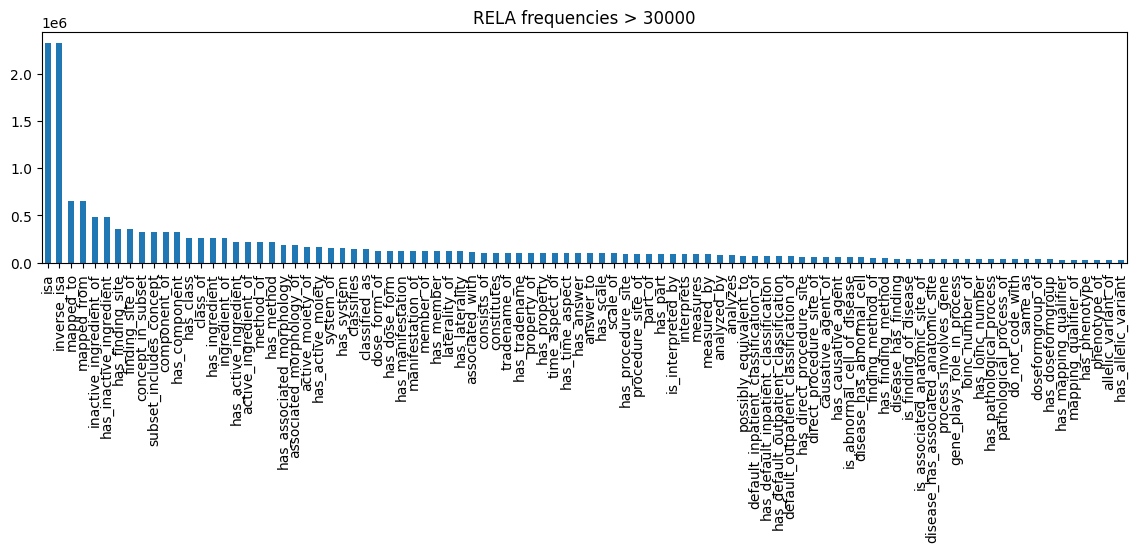

In [3]:
dataset = "UMLS"

umls_rel_df = pd.read_csv(paths[dataset]['rels'])
display(umls_rel_df.head(5))

print("Size of relationship detection set:", umls_rel_df.shape[0])
print(f"Number of relationships:{len(umls_rel_df['RELA'].value_counts())}")

fig, axs = plt.subplots(1, 1, figsize=(14,3), sharex=True)
umls_rel_df['RELA'] .value_counts().loc[lambda X: X>30000].plot(ax=axs, kind='bar')
axs.set_title('RELA frequencies > 30000')

--------------------------

### Entity Type Detection Set
- Total number of entities that we obtained from relationship detection set is:‌ **2,093,042** (we ignored duplicates)
- Examples (CUIs): `['C0000039', 'C0000052', 'C0000084', 'C0000096', 'C0000097', 'C0000098', 'C0000102', 'C0000103', 'C0000107', 'C0000139', 'C0000163', 'C0000165', 'C0000167', 'C0000172', 'C0000173', 'C0000176', 'C0000184', 'C0000189', 'C0000194', 'C0000204']`
- Examples (CUIs with Names): `C0000052`: **ALPHA GLUCAN BRANCHING ENZYME 01 04** , `C0000172`:**18-Hydroxycorticosterone (substance)**
- In total, we obtained **127** entity types using `MRSTY.RRF` semantic network of UMLS

In [4]:
umls_ent_df = pd.read_csv(paths[dataset]['entities'])
print("Size of entity type detection set:", umls_ent_df.shape[0])
display(umls_ent_df.head(5))

Size of entity type detection set: 2093042


,CUI,STR,TUIs,STNs,level-1,level-2,level-3
0,C0000039,DIPALMITOYLPHOSPHATIDYLCHOLINE 0102,"['T109', 'T121']","['A1.4.1.2.1', 'A1.4.1.1.1']",A1,A1.4,A1.4.1
1,C0000052,ALPHA GLUCAN BRANCHING ENZYME 01 04,"['T116', 'T126']","['A1.4.1.2.1.7', 'A1.4.1.1.3.3']",A1,A1.4,A1.4.1
2,C0000084,CARBOXYGLUTAMIC ACID 01,"['T116', 'T123']","['A1.4.1.2.1.7', 'A1.4.1.1.3']",A1,A1.4,A1.4.1
3,C0000096,METHYLISOBUTYLXANTHINE 01 03,"['T109', 'T121']","['A1.4.1.2.1', 'A1.4.1.1.1']",A1,A1.4,A1.4.1
4,C0000097,"1-Methyl-4-Phenyl-1,2,3,6-Tetrahydropyridine (...","['T109', 'T131']","['A1.4.1.2.1', 'A1.4.1.1.5']",A1,A1.4,A1.4.1


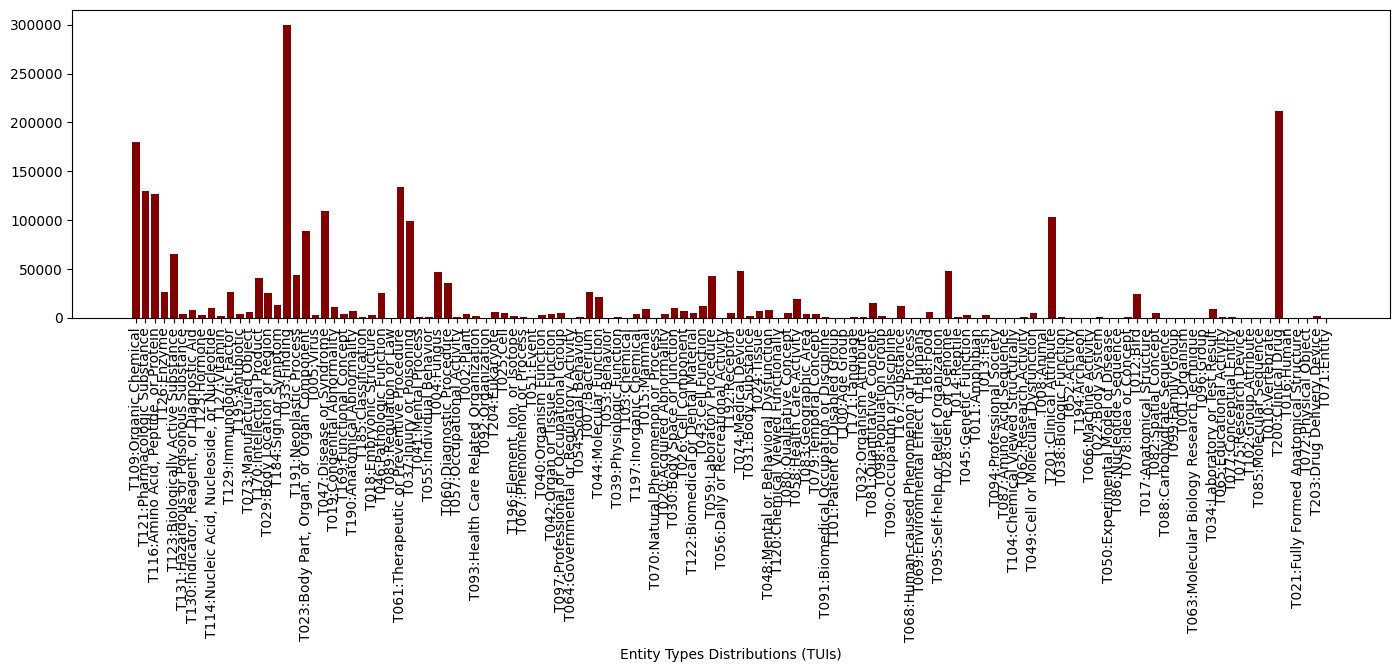

In [6]:
fig = plt.figure(figsize=(17, 4))
with open(paths[dataset]['tui-2-str'], "r") as js_file:
    umls_end_def_js = json.load(js_file)
    
entity_types_tuis = defaultdict(int)
for entity_type in umls_ent_df['TUIs'].tolist():
    for entity in eval(entity_type):
        entity_types_tuis[entity+":"+umls_end_def_js[entity]] += 1

plt.bar(list(entity_types_tuis.keys()), list(entity_types_tuis.values()), color ='maroon')
plt.xlabel("Entity Types Distributions (TUIs)")
plt.xticks(rotation=90)
plt.show()

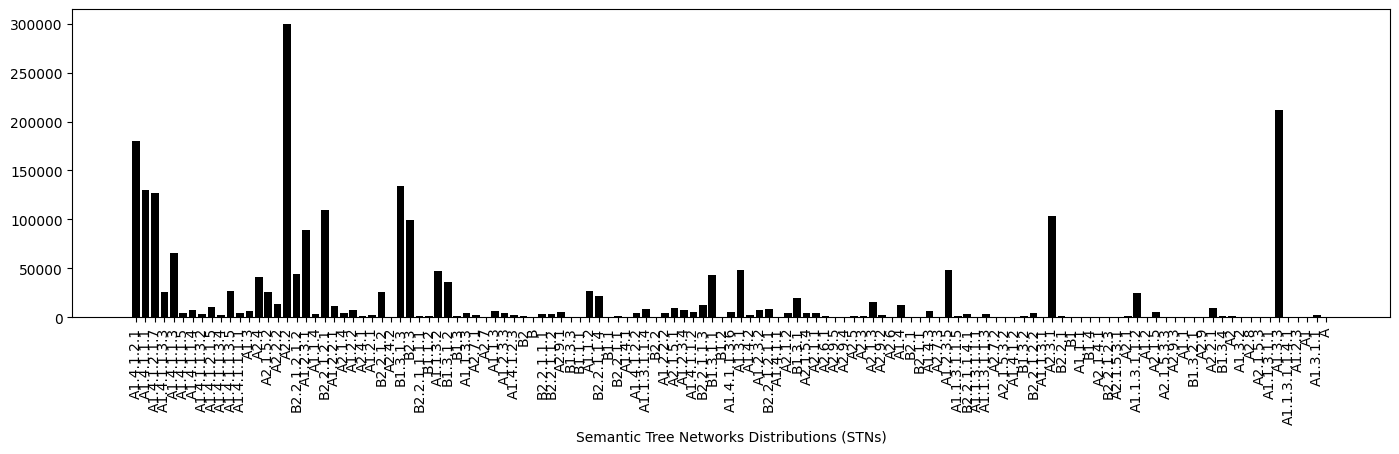

In [7]:
fig = plt.figure(figsize=(17, 4))

entity_types_stns = defaultdict(int)
for entity_type in umls_ent_df['STNs'].tolist():
    for entity in eval(entity_type):
        entity_types_stns[entity] += 1        

plt.bar(list(entity_types_stns.keys()), list(entity_types_stns.values()), color ='black')
plt.xlabel("Semantic Tree Networks Distributions (STNs)")
plt.xticks(rotation=90)
plt.show()


* **Note:** Entity and Semantic Tree Networks definitions comes from `MRSTY.RRF`
* Top frequent Entity Types:
|#|TUI|Frequency|Definition|
|:---:|:---:|:---:|:---:|
|1 |  T033  |  300082  |  Finding | 
 | 2 |  T200,  |  211398  | Clinical Drug |
 | 3 |   T109 | 180450| Organic Chemical|
 | 4 |   T061 | 133993| Therapeutic or Preventive Procedure|
 | 5 |   T121 | 129641| Pharmacologic Substance|
 | 6 |   T116 | 127037| Amino Acid, Peptide, or Protein|
 | 7 |   T047 | 109312| Disease or Syndrome|
 | 8 |   T201 | 103481| Clinical Attribute|
 | 9 |   T037 | 99423| Injury or Poisoning|
 | 10 |   T023 | 89363| Body Part, Organ, or Organ Component|


### Entities hierarchy

We considered `STNs` to obtain entity types Hierarchy, since STNs are tree number of the semantic type. STN, A tree number indicating its position in the `isa` hierarchy, as mentioned here [13].



Hierarchy mapper view:

```json
"Entity" ---> T071 ---> A
    "Physical Object" --->‌ T072 --->‌ A1
        "Organism" ---> T001 ---> A1.1
                "Eukaryote" ---> T204 ---> A1.1.3
                        "Animal" --->‌ T008 ---> A1.1.3.1
                                "Vertebrate" ---> T010 ---> A1.1.3.1.1
        "Anatomical Structure"
        "Manufactured Object"
        "Substance"

    "Conceptual Entity" --->‌ T077 ---> A2
        "Idea or Concept" ---> T078 ---> A2.1
        "Finding"
        "Organism Attribute" 
        "Intellectual Product" 
        "Language"
        "Occupation or Discipline"
        "Organization"
        "Group Attribute" 
        "Group"

"Event" ---> T051 ---> A
    "Activity" ---> T052 ---> B1
        "Behavior" ---> T053  --->  B1.1
        "Daily or Recreational Activity" 
        "Occupational Activity"
        "Machine Activity"

    "Phenomenon or Process" ---> T067 ---> B2
        "Human-caused Phenomenon or Process" ---> T068   --->  B2.1
        "Natural Phenomenon or Process"
        "Injury or Poisoning"
```
According to hierarchy avaliable in [semantic types hierarchy](https://www.nlm.nih.gov/research/umls/META3_current_semantic_types.html). Processing tree numbers will allow us to dive deeper in the types.However we only considered processing until level-3.

For Level1 we started from `[A, A1, A2, B, B2, B1` nodes and Level-2 started from `A1.*, A2.*, B1.*, B2.*`. Moreover Level-3 started from `A1.1.*, ... A2.1.*, ....  B1.1.*,.... B2.1.*, ...`


At the end we obtained following stats levels:

- Level 1 with 6 root node and with in total 127 unique semantic types.
- Level 2 with 20 root node and with in total 121 unique semantic types.
- Level 3 with 40 root node and with in total 101 unique semantic types.


**To make things easier we took the same approach that available in Geonames hierarchy creation here**

Text(0.5, 1.0, 'Level 3')

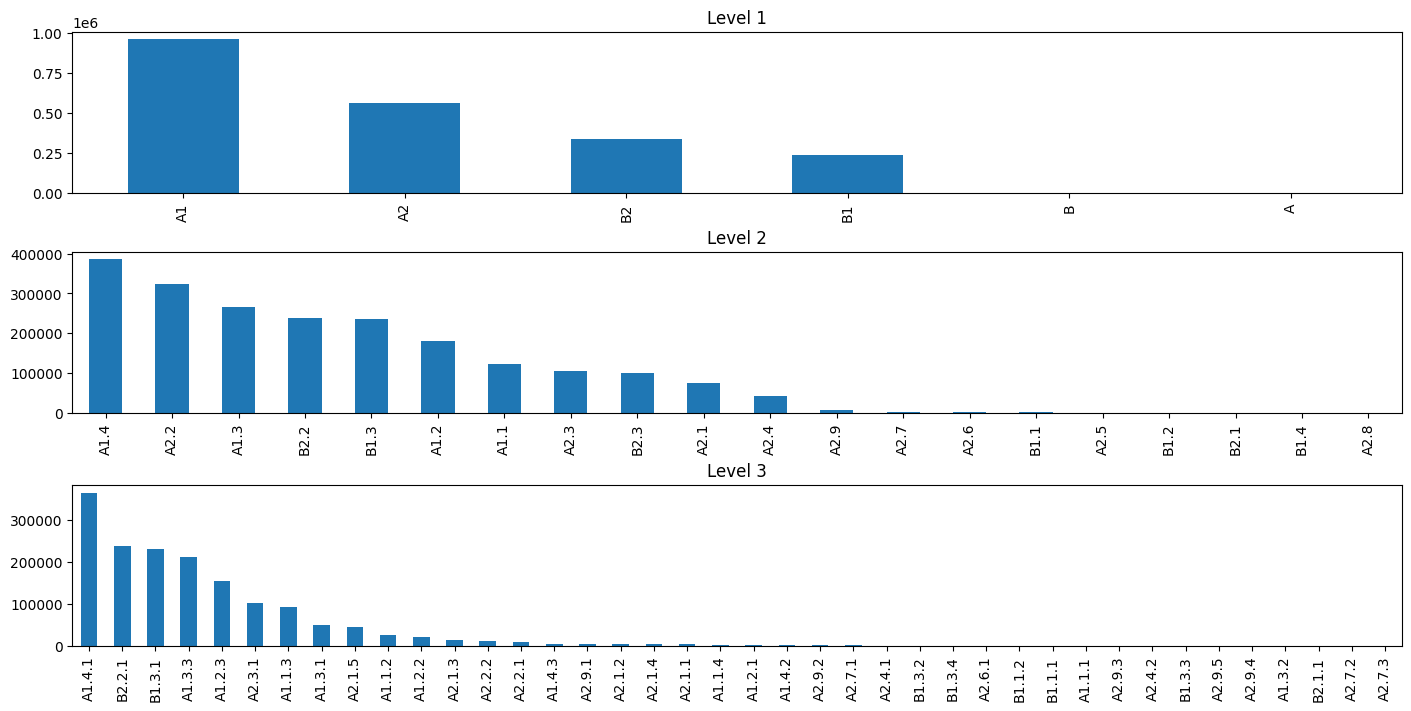

In [22]:
fig, axs = plt.subplots(3, 1, figsize=(14,7), constrained_layout=True)

umls_ent_df['level-1'] .value_counts().plot(ax=axs[0], kind='bar')
axs[0].set_title('Level 1')

umls_ent_df['level-2'] .value_counts().plot(ax=axs[1], kind='bar')
axs[1].set_title('Level 2')

umls_ent_df['level-3'] .value_counts().plot(ax=axs[2], kind='bar')
axs[2].set_title('Level 3')

-------------------------------
### Refrences
- [0] Source: `datasets/UMLS/raw/umls-2022AB-metathesaurus-full/2022AB/META/MRCONSO.ctl`
- [1] [CH-2 Metathesaurus](https://www.ncbi.nlm.nih.gov/books/NBK9684/)
- [2] [Abbreviations Used in Data Elements - 2022AB Release](https://www.nlm.nih.gov/research/umls/knowledge_sources/metathesaurus/release/abbreviations.html)
- [3] [UMLS Metathesaurus Vocabulary Documentation](https://www.nlm.nih.gov/research/umls/sourcereleasedocs/index.html)
- [4] [Columns and Data Elements - 2022AB](https://www.nlm.nih.gov/research/umls/knowledge_sources/metathesaurus/release/columns_data_elements.html)
- [5] [Source and Term Types: Default Order of Precedence and Suppressibility - 2022AB Release](https://www.nlm.nih.gov/research/umls/knowledge_sources/metathesaurus/release/precedence_suppressibility.html)
- [6] [CH-3 Metathesaurus - Rich Release Format (RRF)](https://www.ncbi.nlm.nih.gov/books/NBK9685/)
- [7] https://www.ncbi.nlm.nih.gov/books/NBK9685/table/ch03.T.concept_names_and_sources_file_mr/?report=objectonly
- [8] [CH-5 Semantic Network](https://www.ncbi.nlm.nih.gov/books/NBK9679/)
- [9] [TTY variants](https://www.nlm.nih.gov/research/umls/knowledge_sources/metathesaurus/release/abbreviations.html#mrdoc_TTY)
- [10] [REL variants](https://www.nlm.nih.gov/research/umls/knowledge_sources/metathesaurus/release/abbreviations.html#mrdoc_REL)
- [11] [Past Versions of the Semantic Network and Semantic Groups Files](https://lhncbc.nlm.nih.gov/semanticnetwork/SemanticNetworkArchive.html)
- [12] [Semantic Network page](https://lhncbc.nlm.nih.gov/semanticnetwork/)
- [13] [Metathesaurus Data Files](https://www.nlm.nih.gov/research/umls/new_users/online_learning/Meta_006.html)
- [14] [Identifiers in the Semantic Network](https://www.nlm.nih.gov/research/umls/new_users/online_learning/SEM_002.html)